# PPG Pre-processing and HRV Feature Extraction Evaluation

As part of my understanding of the PPG and ECG signal, this notebok represent as the Attemp to see and visualize the Feature Extraction with some Preprocessing signal, also for the result comparsion, I will use the Kubios HRV to see how much the difference with the Signal that I'm processing.

Since the point in the HRV is the RR-Interval analysis. The key point is to measure the distance-time for each true peak heart beat signal. Let's see in the action.

### Hypothesis
The peak in the graph, is suppposed to be the heart beat.

Based on some hypotesis:
1. Physiological Range: The RR intervals should typically be within the range of 300 ms (0.3 s) to 1300 ms (1.3 s). This range corresponds to heart rates between approximately 46 bpm and 200 bpm, which covers most normal physiological conditions1.
2. Removal of Erroneous Peaks: Intervals shorter than 300 ms may indicate erroneous detections, such as additional peaks that do not correspond to actual heartbeats. These should be filtered out to maintain data integrity1.


### Notes:
The dataset used for the purpose is 2-3 minute length dataset. Since HRV analysis require to have minimum 2 minute length for Frequency Analysis.

**More length signal makes more clean HRV analysis, But for the Real-Time. This will do.**

In [152]:
## Importing the necessary libraries
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
## Open the Dataset Ground truth from the Samples Directory
ground_truth = pd.read_csv("../../Samples/Original/bvp_s55_T3.csv", header=None).values.flatten()

### Notes:
As part of make the Sampling rate uniform, let's set the sampling rate around 35 Hz. Since the Ground truth dataset has 64 Hz record sampling rate, the Downsampling is required.

In [154]:
# Downsampling the Ground truth from 64 Hz to 35 Hz

## Original Sampling Frequency
original_fs = 64.0

## Target Sampling Frequency
target_fs = 35.0

## Downsampling Factor
downsampling_factor = int(len(ground_truth) / (original_fs / target_fs))

## Resample the Ground truth
downsampled_ground_truth = scipy.signal.resample(ground_truth, downsampling_factor)

## Print the new length of the Ground truth
print("Original Length: ", len(ground_truth))
print("Downsampled Length: ", len(downsampled_ground_truth))

Original Length:  11520
Downsampled Length:  6300


<hr style="border:20px solid red; border-radius:5px">

### Crop the Signal Into 2 Minute Length (Optional)


In [155]:
## Crop the signal into 2 minute length
downsampled_ground_truth = downsampled_ground_truth[:int(2 * target_fs * 60)]

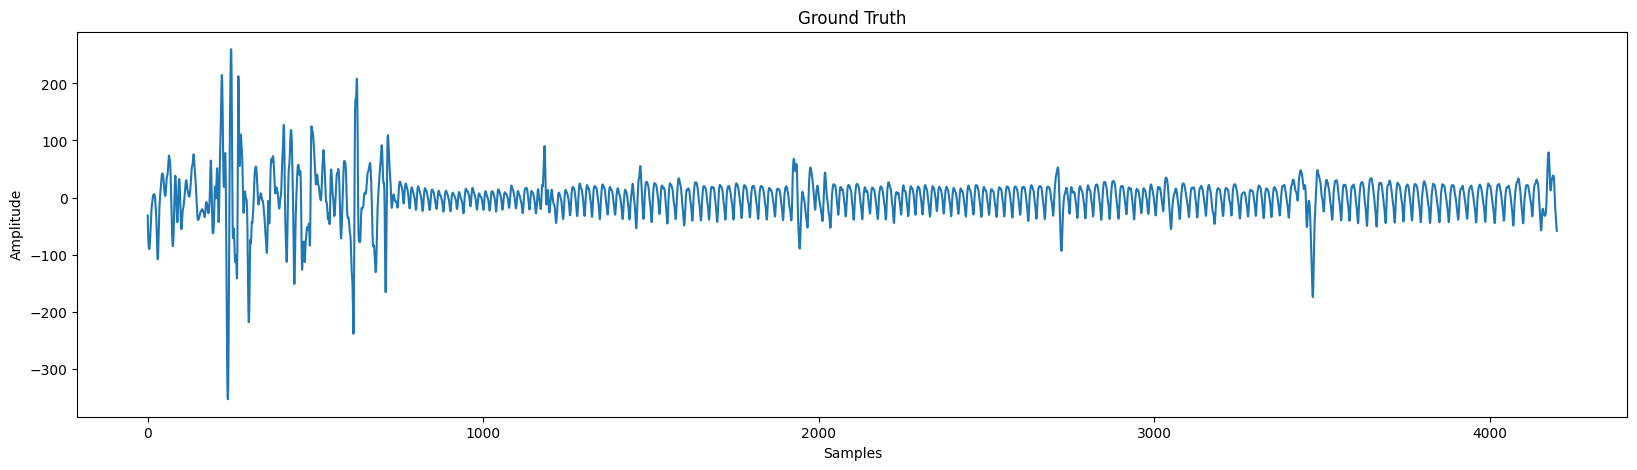

In [156]:
## Plot the Ground truth
plt.figure(figsize=(20, 5))
plt.plot(downsampled_ground_truth)
plt.title("Ground Truth")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Consecutive Function for Preprocessing the Signal.

As pre-processing pipeline require you to setup some steps before working with the signal data. But there's the task that are going to do.
1. Preprocessing pipeline
2. RR Interval Calculation
3. Artificial Detection and Correction

In [157]:
def preprocess_signal(rppg_signal, fs):
    """Trivial Method
    Preprocess the raw PPG signal to extract the heart rate signal.
    """
    # Narrower bandpass around expected heart rate frequencies (0.8-2.0 Hz)
    b, a = scipy.signal.butter(3, [0.8, 2.0], btype='band', fs=fs)
    filtered = scipy.signal.filtfilt(b, a, rppg_signal)
    
    # Additional lowpass to remove high-frequency noise
    b2, a2 = scipy.signal.butter(3, 2.5, btype='low', fs=fs)
    filtered = scipy.signal.filtfilt(b2, a2, filtered)
    
    # Moving average smoothing
    window = int(fs * 0.15)  # 150ms window
    smoothed = np.convolve(filtered, np.ones(window)/window, mode='same')
    
    return smoothed

In [158]:
def preprocess_ppg(signal, fs = 35):
    """ Computes the Preprocessed PPG Signal, this steps include the following:
        1. Moving Average Smoothing
        2. Bandpass Filtering
        3. Normalization
        
        Parameters:
        ----------
        signal (numpy array): 
            The PPG Signal to be preprocessed
        fs (float): 
            The Sampling Frequency of the Signal
            
        Returns:
        --------
        numpy array: 
            The Preprocessed PPG Signal
    
    """ 

    ## Moving Average Smoothing
    window = int(fs * 0.15)  # 150ms window
    smoothed_signal = np.convolve(signal, np.ones(window)/window, mode='same')

    b, a = scipy.signal.butter(3, [0.8, 2.0], btype='band', fs=fs)
    filtered = scipy.signal.filtfilt(b, a, smoothed_signal)
    
    # Additional lowpass to remove high-frequency noise
    b2, a2 = scipy.signal.butter(3, 2.5, btype='low', fs=fs)
    filtered = scipy.signal.filtfilt(b2, a2, filtered)
    
    # Moving average smoothing
    window = int(fs * 0.15)  # 150ms window
    filtered_signal = np.convolve(filtered, np.ones(window)/window, mode='same')

    # Normalize using Standard Deviation
    normalized_signal = (filtered_signal - filtered_signal.mean()) / filtered_signal.std()

    return normalized_signal


In [159]:
def get_rr_interval(signal, fs = 35):
    """Computes the distance between each peak in the signal

    Parameters:
    ----------
    signal (numpy array): 
        The PPG Signal to be preprocessed
    fs (float):
        The Sampling Frequency of the Signal
    
    Returns:
    --------
    numpy array: 
        The RR Interval Signal
    
    Notes:
    ------
    Since the signal is already being preprocessed and normalize around 0 and 1, 
    It suppose have the maximum amplitude peak at 1. 
    .
    Using the adaptive thresholding method to detect the peaks in the signal
    should potentially give a better result with different threshold on the moving window.

    """

    ## Adaptive thresholding
    window_size = fs * 2  # 2-second window
    rolling_mean = np.convolve(signal,
                              np.ones(window_size)/window_size, 
                              mode='same')
    adaptive_threshold = rolling_mean + 0.5 * np.std(signal)

    peaks, properties = scipy.signal.find_peaks(signal,
                                               distance=fs * 0.5, # 0.5-second distance between peaks   
                                               prominence=0.1,  # Consider peak prominence
                                               height=adaptive_threshold)
    ## Convert into time
    rr_interval = np.diff(peaks) / fs

    return rr_interval

In [160]:
def clean_rr_interval(rr_interval):
    """Clean the RR Interval Signal by removing the outliers

    Parameters:
    ----------
    rr_interval (numpy array): 
        The RR Interval Signal to be cleaned
    
    Returns:
    --------
    numpy array: 
        The Cleaned RR Interval Signal
    
    Notes:
    ------
    The RR Interval Signal is cleaned by removing the outliers, 
    A typical physiological limit for an RR interval is considered to be between 0.6 and 1.2 seconds (or 600-1200 milliseconds),
    which translates to a normal resting heart rate range of roughly 60-100 beats per minute; 

    """

    ## Remove physical impossible values
    # Convert to milliseconds
    rr_ms = rr_interval
    	
    # Physiological limits (typically 600-1200 ms)
    valid_rr = rr_ms[(rr_ms >= 0.6) & (rr_ms <= 1.2)]
    
    # Check for dramatic changes
    rr_diff = np.abs(np.diff(valid_rr))
    valid_rr = valid_rr[np.where(rr_diff < 0.2 * valid_rr[:-1])[0]]

    return valid_rr

<hr style="border:20px solid green; border-radius:5px">

### Let's Code
Let's take the feature out of the RR interval

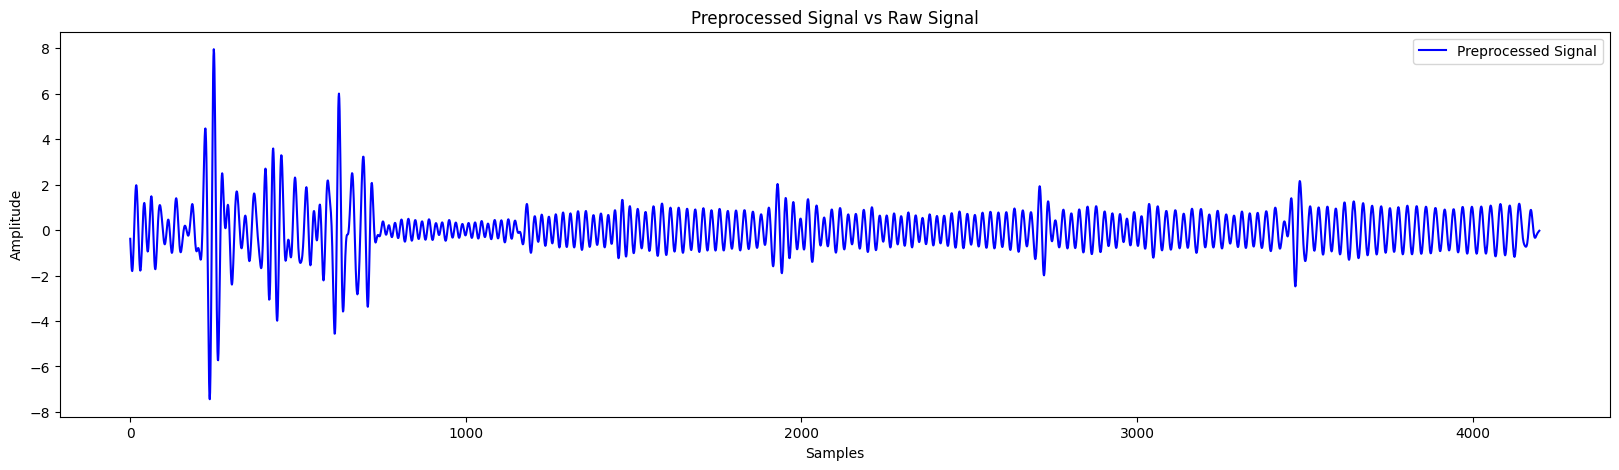

In [161]:
## Preprocess Signal and display 
preprocessed_signal = preprocess_ppg(downsampled_ground_truth)

## Display the Preprocessed Signal
plt.figure(figsize=(20, 5))
# plt.plot(downsampled_ground_truth, label="Raw Signal", color="red")
plt.plot(preprocessed_signal, label="Preprocessed Signal", color="blue")
plt.title("Preprocessed Signal vs Raw Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


### Notes: Let's calculate the Peaks
Well let's see the current peaks

The HR : 196 / 180 *  60

Number of peaks detected in smoothed signal: 155


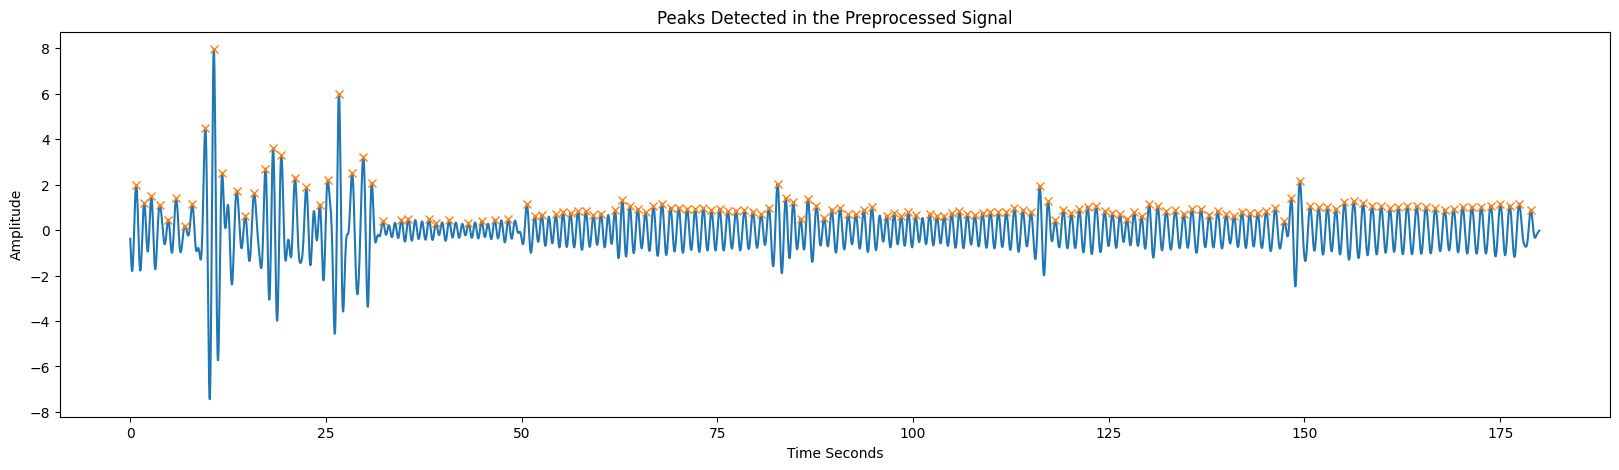

In [162]:
smoothed_peaks, smoothed_properties = scipy.signal.find_peaks(preprocessed_signal, distance=35 * 0.6, prominence=0.1) # Adjusted prominence for smoothed signal
print(f"Number of peaks detected in smoothed signal: {len(smoothed_peaks)}")

duration = 180 # 3 minutes

## Create a linspace of the duration
time = np.linspace(0, duration, len(preprocessed_signal))

## Plot peaks on the Preprocessed Signal
plt.figure(figsize=(20, 5))
plt.plot(time, preprocessed_signal)
plt.plot(time[smoothed_peaks], preprocessed_signal[smoothed_peaks], "x")
plt.title("Peaks Detected in the Preprocessed Signal")
plt.xlabel("Time Seconds")
plt.ylabel("Amplitude")
plt.show()



Len RR Interval:  144
Len Cleaned RR Interval:  121


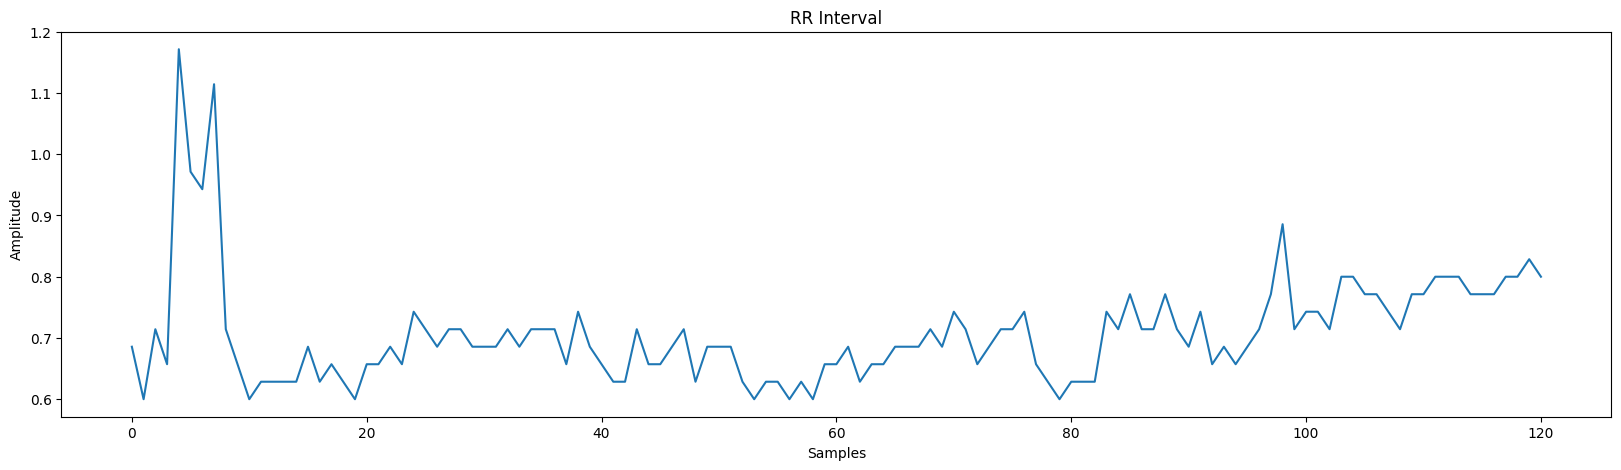

In [163]:
## Get RR Interval
rr_interval = get_rr_interval(preprocessed_signal)
print("Len RR Interval: ", len(rr_interval))

## Clean RR Interval
cleaned_rr_interval = clean_rr_interval(rr_interval)
print("Len Cleaned RR Interval: ", len(cleaned_rr_interval))

## Plot the RR Interval
plt.figure(figsize=(20, 5))
plt.plot(cleaned_rr_interval)
plt.title("RR Interval")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


<hr style="border:20px solid blue; border-radius:5px">

### Feature Engineering
Let's take the feature out of the RR interval

In [164]:
def extract_time_features(rr_intervals):
    """Extract time-domain features from the RR intervals

    Parameters:
    ----------
    rr_intervals (numpy array): 
        The RR Interval Signal

    Returns:    
    --------
    dict: 
        Dictionary containing the extracted features

    """
    features = {
        'mean_rr': np.mean(rr_intervals),
        'sdnn': np.std(rr_intervals),
        'rmssd': np.sqrt(np.mean(np.diff(rr_intervals)**2)),
        'pnn50': (np.diff(rr_intervals) > 0.05).mean() * 100,
        'hr': 60 / np.mean(rr_intervals)
    }
    return features


In [165]:
def frequency_analysis(rr_intervals, fs_interp=4.0):
    """Extract frequency-domain features from the RR intervals

    Parameters:
    ----------
    rr_intervals (numpy array): 
        The RR Interval Signal
    fs_interp (float):
        The Interpolated Sampling Frequency

    Returns:
    --------
    dict: 
        Dictionary containing the extracted features

    """
    # Interpolate to uniform sampling
    time_points = np.cumsum(rr_intervals)
    f_interp = scipy.interpolate.interp1d(time_points, rr_intervals, kind='cubic')
    
    # Create uniform time axis
    t_uniform = np.arange(time_points[0], time_points[-1], 1/fs_interp)
    rr_uniform = f_interp(t_uniform)
    
    # Welch's method
    frequencies, psd = scipy.signal.welch(rr_uniform, fs=fs_interp, nperseg=256)
    
    # Calculate frequency bands
    vlf = np.trapz(psd[(frequencies >= 0.0033) & (frequencies < 0.04)])
    lf = np.trapz(psd[(frequencies >= 0.04) & (frequencies < 0.15)])
    hf = np.trapz(psd[(frequencies >= 0.15) & (frequencies < 0.4)])

    ## Plot the PSD in more detail for each frequency band
    plt.figure(figsize=(20, 5))
    plt.plot(frequencies, psd)
    plt.fill_between(frequencies, psd, where=(frequencies >= 0.0033) & (frequencies < 0.04), color='red', alpha=0.5)
    plt.fill_between(frequencies, psd, where=(frequencies >= 0.04) & (frequencies < 0.15), color='green', alpha=0.5)
    plt.fill_between(frequencies, psd, where=(frequencies >= 0.15) & (frequencies < 0.4), color='blue', alpha=0.5)
    plt.title("Power Spectral Density")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.show()
    
    
    return {'vlf': vlf, 'lf': lf, 'hf': hf, 'lf_hf_ratio': lf/hf}

Time Features:  {'mean_rr': 0.707201889020071, 'sdnn': 0.08733462490623481, 'rmssd': 0.07824607964359517, 'pnn50': 15.833333333333332, 'hr': 84.8414023372287}


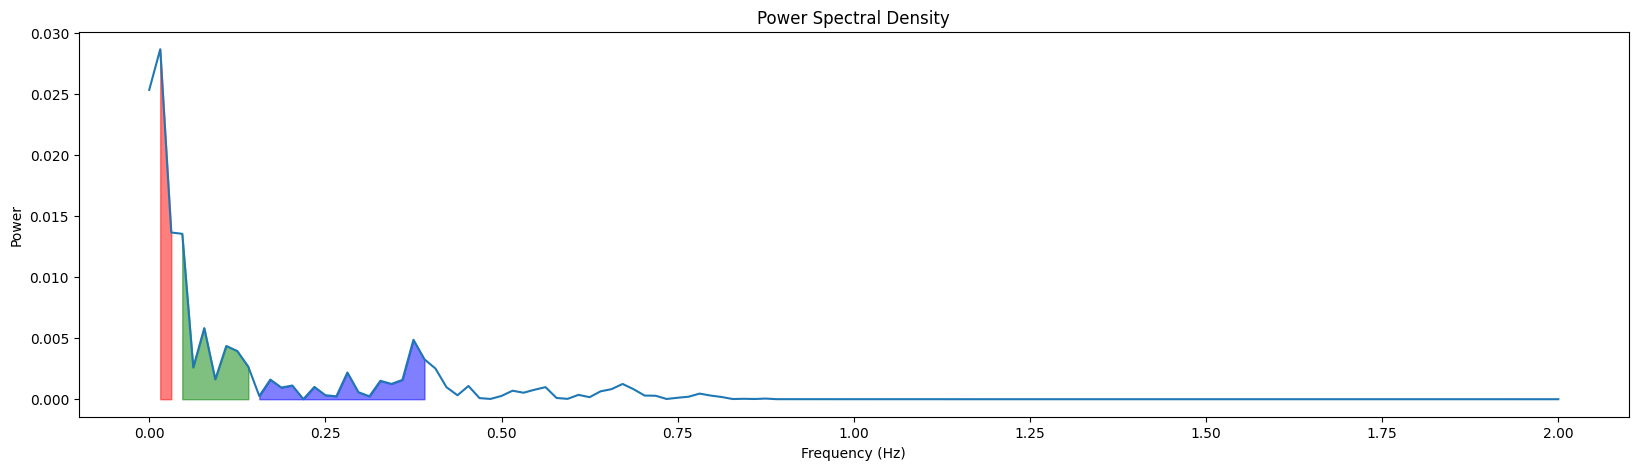

Frequency Features:  {'vlf': 0.021146281866565888, 'lf': 0.026445872903572226, 'hf': 0.019227593925006996, 'lf_hf_ratio': 1.3754124934569838}


In [166]:
## Get the Time Features
time_features = extract_time_features(cleaned_rr_interval)
print("Time Features: ", time_features)

## Get the Frequency Features
frequency_features = frequency_analysis(cleaned_rr_interval)
print("Frequency Features: ", frequency_features)
